In [ ]:
# %matplotlib widget
%matplotlib inline
from IPython.display import display, Image
import matplotlib.pyplot as plt
plt.rcParams['axes.facecolor'] = 'magenta' # makes transparent pixels obvious

In [2]:
from dask.distributed import Client, wait as dask_wait
from datacube.utils.dask import start_local_dask
from datacube.utils.rio import configure_s3_access

client = start_local_dask(scheduler_port=11312,
                          threads_per_worker=16)
configure_s3_access(aws_unsigned=True, cloud_defaults=True, client=client)    
client

/env/lib/python3.6/site-packages/distributed/node.py:155: UserWarning: Port 8787 is already in use.
Perhaps you already have a cluster running?
Hosting the HTTP server on port 46463 instead
  http_address["port"], self.http_server.port


Client Scheduler: tcp://127.0.0.1:11312 Dashboard: /user/toki/proxy/46463/status,Cluster Workers: 1 Cores: 16 Memory: 106.85 GB


In [1]:
from datacube import Datacube
from odc.algo import  to_rgba, enum_to_bool, keep_good_only
from odc.ui import to_jpeg_data
import numpy as np

import xarray as xr

def as_jpeg_bytes(rgba, transparent_color=(255,0,255)):
    m = rgba[...,-1] == 0
    rgb = rgba[..., :3].copy()
    rgb[m] = transparent_color
    return to_jpeg_data(rgb)

resampling = 'nearest'
bad_pixel_classes = (0, 'saturated or defective')
cloud_classes = ('cloud shadows', 
                 'cloud medium probability', 
                 'cloud high probability', 
                 'thin cirrus')
granule='31PFM'

dc = Datacube()

dss = dc.find_datasets(product='s2_l2a', 
                       region_code=granule,
                       cloud_cover=(0, 50), # no more than 50% cloud cover
                       time=('2019-06', '2019-08'))

dss = sorted(dss, key=lambda ds: ds.center_time)

ModuleNotFoundError: No module named 'xarray'

In [4]:
import dask.array as da
import xarray as xr
import dask

from skimage.morphology import disk
from dask_image.ndmorph import binary_erosion, binary_dilation

def cloud_buffer(mask: xr.DataArray,
                radius: int,
                dilation_radius: int = None):

    """ This method accepts cloud masks and applies morphological functions to improve cloud masking
        The buffer is formed by applying dilation(dilation_radius) |> erosion(radius + dilation_radius) if
        dilation_radius is specified otherwise just erosion(radius)
        The sequential application of these functions will improve false cloud detection for sandy beaches

        :param mask: A mask which has cloud classes (cloud shadows, cloud medium probability,
                    cloud high probability, thin cirrus) set to False
        :param radius: kernel Radius
        :param dilation_radius: kernel Radius

        example:
        clouds_not = enum_to_bool(xx.scl, cloud_classes, invert=True)
        cloud_buffer(clouds_not, radius, dilation_radius)
    """
    dilation_kernel = disk(dilation_radius) if dilation_radius is not None else None  
    dilation_kernel = disk(dilation_radius)[np.newaxis, :, :] if len(mask.shape) == 3 and dilation_radius is not None else dilation_kernel                           
   
    erosion_radius = radius if dilation_radius is None else (dilation_radius + radius)
    erosion_kernel = disk(erosion_radius)[np.newaxis, :, :] if len(mask.shape) == 3 else disk(erosion_radius)

    if dilation_radius is None:
        return xr.DataArray(data=binary_erosion(mask.data, erosion_kernel, border_value=True), coords=mask.coords)
    else:
        return xr.DataArray(data=binary_erosion(binary_dilation(mask.data, dilation_kernel, border_value=True), erosion_kernel, border_value=True), coords=mask.coords)

In [5]:
all_crs = set(ds.crs for ds in dss)
crs, *_ = all_crs
display(crs, all_crs)
display([ds.metadata.cloud_cover for ds in dss])

NameError: name 'dss' is not defined

In [6]:
xx = dc.load(datasets=dss, 
             output_crs=crs, 
             resolution=(-20, 20),
             measurements=['SCL', 'red', 'green', 'blue'],
             resampling=resampling,
             dask_chunks={'x': 2800, 'y': 2800})

In [7]:
scl = xx.SCL
xx = xx[['red', 'green', 'blue']]

# False -- cloud or cloud shadow
# True  -- otherwise

# enum_to_bool --> np.isin(mask, categories)
    
clouds_not = enum_to_bool(scl, cloud_classes, invert=True)
# Pixels that were clouds replaced with `nodata`
xx_clear = keep_good_only(xx, clouds_not)

# # Convert to RGBA for data visualization
rgba_clear = to_rgba(xx_clear, clamp=(1, 3000))
rgba = to_rgba(xx, clamp=(1, 3000))

distributed.nanny - WARNING - Restarting worker


In [37]:
import dask.array as da
import xarray as xr
import dask

from skimage.morphology import disk
from dask_image.ndmorph import binary_erosion, binary_dilation

def cloud_buffer(mask: xr.DataArray,
                radius: int,
                dilation_radius: int = None):

    """ This method accepts cloud masks and applies morphological functions to improve cloud masking
        The buffer is formed by applying dilation(dilation_radius) followed by erosion(radius + dilation_radius) if
        dilation_radius is specified otherwise just erosion(radius)
        The sequential application of these functions will improve false cloud detection for sandy beaches

        :param mask: A mask which has cloud classes (cloud shadows, cloud medium probability,
                    cloud high probability, thin cirrus) set to False
        :param radius: kernel radius
        :param dilation_radius: kernel Radius

        example:
        clouds_not = enum_to_bool(xx.scl, cloud_classes, invert=True)
        cloud_buffer(clouds_not, radius, dilation_radius)
    """
    dilation_kernel = disk(dilation_radius) if dilation_radius is not None else None
    if len(mask.shape) == 3 and dilation_radius is not None:
        dilation_kernel = disk(dilation_radius)[np.newaxis, :, :]

    erosion_radius = radius if dilation_radius is None else (dilation_radius + radius)
    if len(mask.shape) == 3:
        erosion_kernel = disk(erosion_radius)[np.newaxis, :, :]
    else:
        erosion_kernel = disk(erosion_radius)

    if dilation_radius is None:
        return xr.DataArray(data=binary_erosion(mask.data, erosion_kernel, border_value=True),
                            coords=mask.coords)
    else:
        return xr.DataArray(data=binary_erosion(binary_dilation(mask.data, dilation_kernel,
                                                border_value=True),
                                                erosion_kernel, border_value=True),
                                                coords=mask.coords)


In [ ]:
radius = 5
good_buffered_data = keep_good_only(xx, cloud_buffer(clouds_not, radius, 3))
rgba_buffered_data = to_rgba(good_buffered_data, clamp=(1, 3000)) 

In [ ]:
%%time
rgba = rgba.compute()

In [27]:
%%time
rgba_clear = rgba_clear.compute()

CPU times: user 691 ms, sys: 898 ms, total: 1.59 s
Wall time: 4.7 s


In [28]:
%%time
clouds_not = clouds_not.compute()

CPU times: user 196 ms, sys: 124 ms, total: 320 ms
Wall time: 871 ms


In [39]:
%%time
rgba_buffered_data = rgba_buffered_data.compute()

CPU times: user 939 ms, sys: 773 ms, total: 1.71 s
Wall time: 8.65 s


In [40]:
results = {}
results['rgba'] = rgba
results['rgba_clear'] = rgba_clear
results['buffered_data'] = rgba_buffered_data

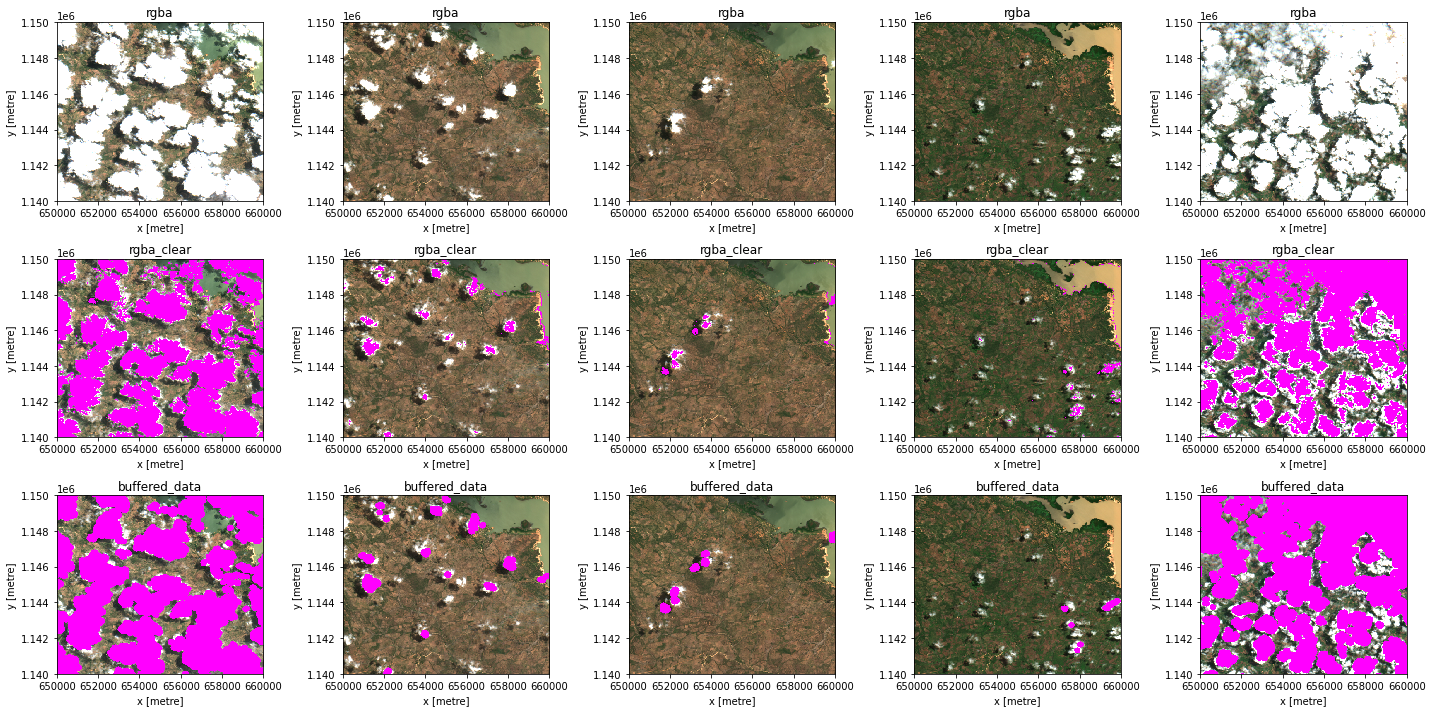

In [41]:
y = 0
fig, axes = plt.subplots(3, 5, figsize=(20,10))

for lbl, d in results.items():   
    for idx in np.arange(0,5):
        d[:5, 2500:3000, 2500:3000].isel(time=idx).plot.imshow(ax=axes[y,idx])
        axes[y,idx].set_title(lbl)
    y += 1
plt.tight_layout()
fig.savefig("output/masked.png")